In [1]:
import os
import pandas as pd
import numpy as np
import re
import json
from collections import defaultdict
from tqdm import tqdm
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import random
from PIL import Image

In [2]:
df = pd.read_csv('/home/vito/fortunom/projects/AI4Health/data/fortunom/covidxct/proc_slices_metadata.csv')
df = df[df["use"]==True]
df.head()

,fname,image_path,patient_id,series_num,age,age_group,sex,finding,label,use,split
0,NCP_1002_2561_0020.png,/home/vito/fortunom/projects/AI4Health/data/fo...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test
1,NCP_1002_2561_0021.png,/home/vito/fortunom/projects/AI4Health/data/fo...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test
2,NCP_1002_2561_0022.png,/home/vito/fortunom/projects/AI4Health/data/fo...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test
3,NCP_1002_2561_0023.png,/home/vito/fortunom/projects/AI4Health/data/fo...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test
4,NCP_1002_2561_0024.png,/home/vito/fortunom/projects/AI4Health/data/fo...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168694 entries, 0 to 168693
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   fname       168694 non-null  object 
 1   image_path  168694 non-null  object 
 2   patient_id  168694 non-null  object 
 3   series_num  19034 non-null   float64
 4   age         168694 non-null  float64
 5   age_group   168694 non-null  object 
 6   sex         168694 non-null  object 
 7   finding     168694 non-null  object 
 8   label       168694 non-null  int64  
 9   use         168694 non-null  bool   
 10  split       168694 non-null  object 
dtypes: bool(1), float64(2), int64(1), object(7)
memory usage: 13.0+ MB


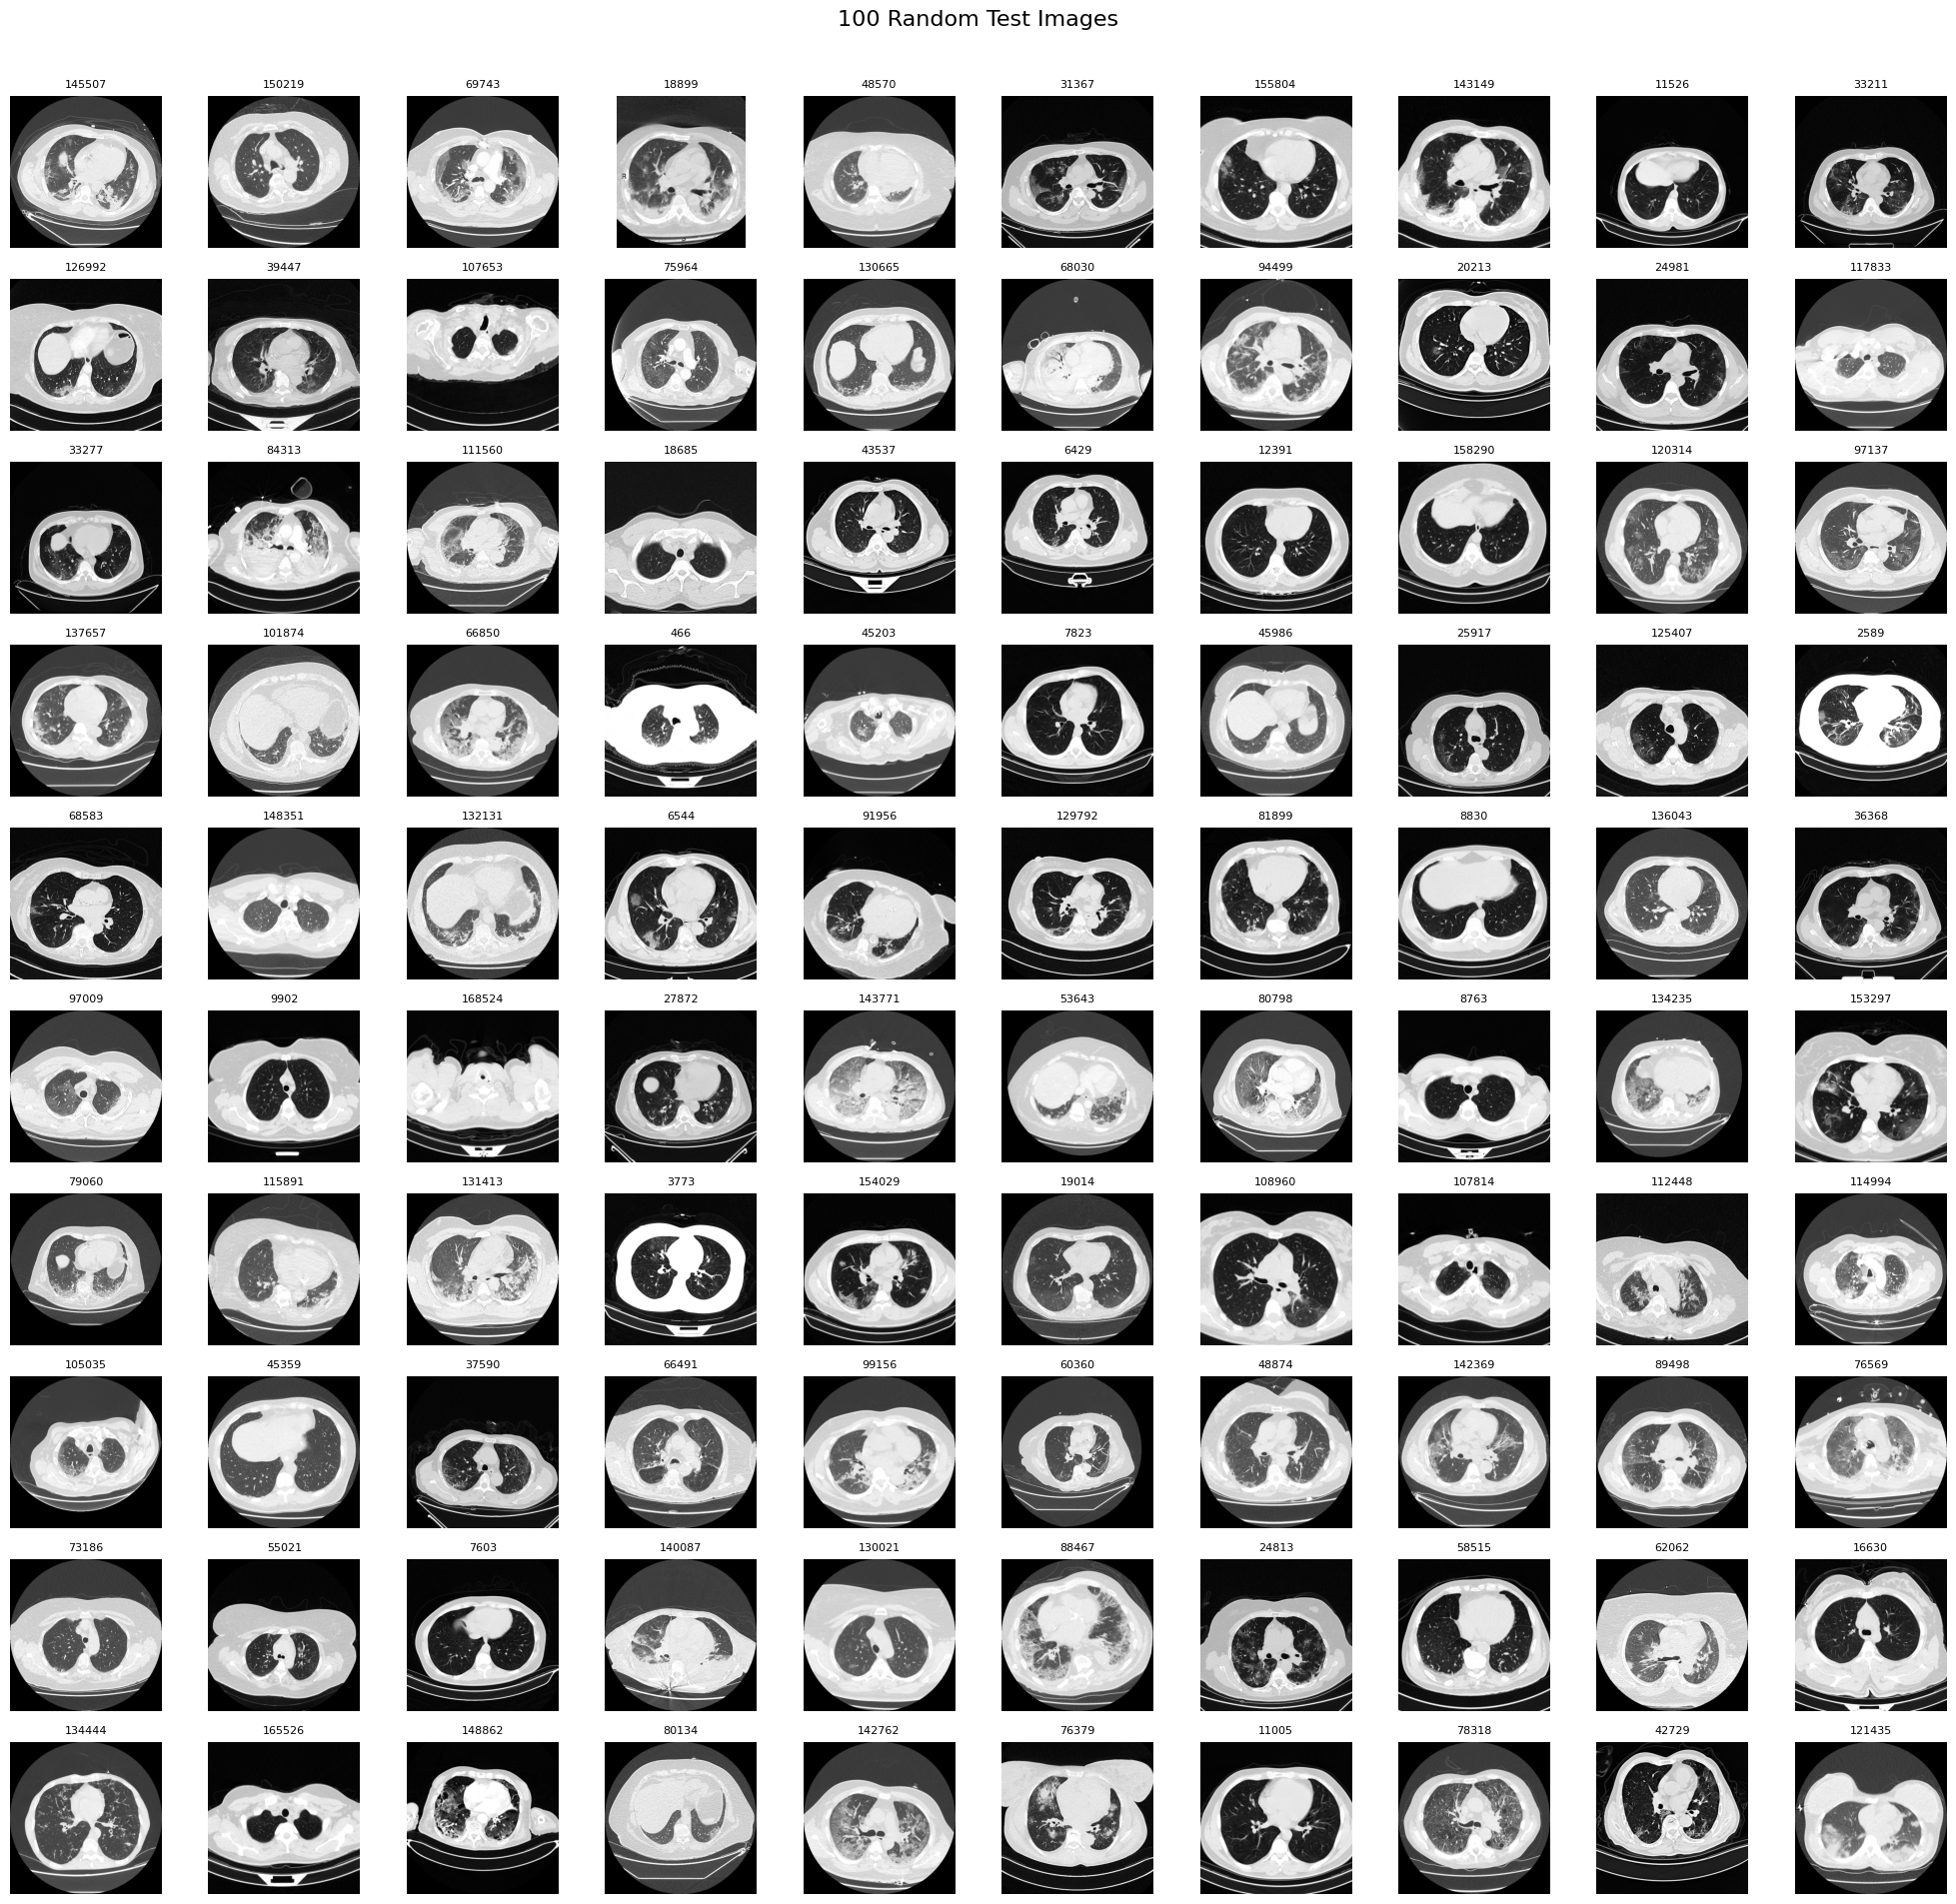

In [23]:
# Sample 100 from the dataset
sample_indices = random.sample(range(len(df)), 100)

# Set up the 10x10 plot grid
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for idx, ax in zip(sample_indices, axes.flatten()):
    image_path = df.iloc[idx]["image_path"]
    img = Image.open(image_path).convert("L")
    img_np = np.array(img)

    ax.imshow(img_np, cmap="gray")
    ax.set_title(f"{idx}", fontsize=8)  # Optional: shorten title to index
    ax.axis("off")

plt.suptitle("100 Random Test Images", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

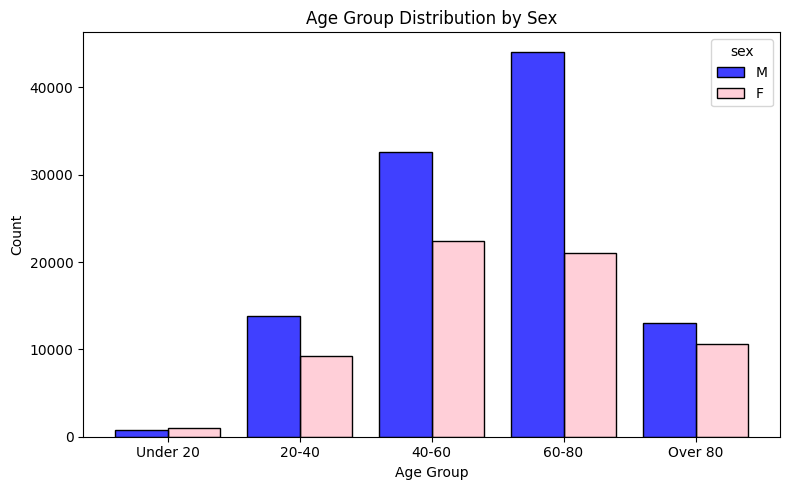

In [6]:
df['age_group'] = pd.Categorical(df['age_group'], categories=['Under 20', '20-40', '40-60', '60-80', 'Over 80'], ordered=True)
df['sex'] = df['sex'].astype(str)

# Create the plot COUNTS
fig, ax = plt.subplots(figsize=(8, 5))
custom_palette = {
    'M': 'blue',
    'F': 'pink'
}

sns.histplot(data=df, x='age_group', hue='sex', multiple='dodge', shrink=0.8, palette=custom_palette, ax=ax)
ax.set_title("Age Group Distribution by Sex")
ax.set_xlabel("Age Group")
ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

In [18]:
df[["sex", "age_group"]].value_counts(normalize=True)

sex  age_group
M    60-80        0.261426
     40-60        0.193166
F    40-60        0.132909
     60-80        0.124800
M    20-40        0.082107
     Over 80      0.077466
F    Over 80      0.062913
     20-40        0.054697
     Under 20     0.006183
M    Under 20     0.004333
Name: proportion, dtype: float64

In [21]:
0.261426+0.193166+0.132909+0.124800

0.7123010000000001

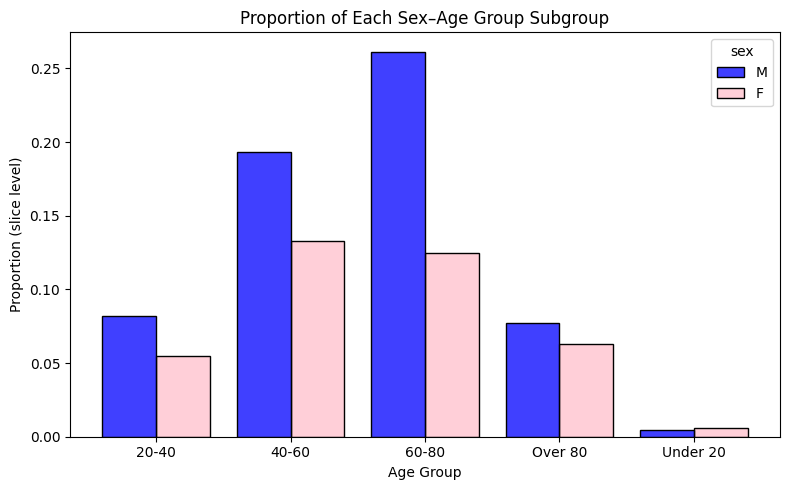

In [5]:
# Assign weights: each row contributes 1 / total_rows
df['weight'] = 1 / len(df)

# Plot histogram with proportions
fig, ax = plt.subplots(figsize=(8, 5))
custom_palette = {'M': 'blue', 'F': 'pink'}

sns.histplot(data=df, x='age_group', hue='sex',
             multiple='dodge', shrink=0.8,
             weights='weight',  # 👈 normalize by total
             palette=custom_palette, ax=ax)

ax.set_title("Proportion of Each Sex–Age Group Subgroup")
ax.set_xlabel("Age Group")
ax.set_ylabel("Proportion (slice level)")

plt.tight_layout()
plt.show()

In [24]:
df["sex"].value_counts(normalize=True)

sex
M    0.618499
F    0.381501
Name: proportion, dtype: float64

In [25]:
df["age_group"].value_counts(normalize=True)

age_group
60-80       0.386226
40-60       0.326076
Over 80     0.140378
20-40       0.136804
Under 20    0.010516
Name: proportion, dtype: float64

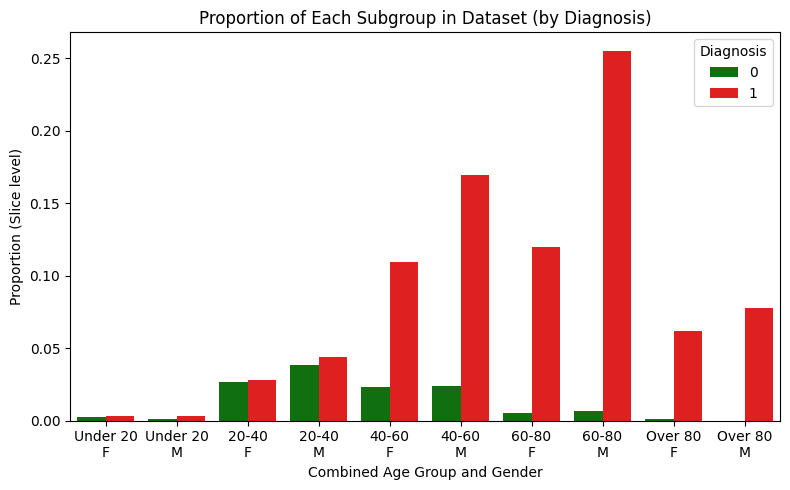

In [36]:
df['group_age_gender'] = df['age_group'].astype(str) + '\n' + df['sex']
# Define the order manually
order = [
    'Under 20\nF', 'Under 20\nM', 
    '20-40\nF', '20-40\nM', 
    '40-60\nF', '40-60\nM', 
    '60-80\nF', '60-80\nM', 
    'Over 80\nF', 'Over 80\nM'
]

diagnosis_palette = {0.0: "green", 1.0:"red"}

# Count each (group_age_gender, label) combination
group_counts = df.groupby(['group_age_gender', 'label']).size().reset_index(name='count')
# Compute proportion of total dataset
group_counts['proportion'] = group_counts['count'] / len(df)

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=group_counts, x='group_age_gender', y='proportion', hue='label',
            order=order, palette=diagnosis_palette, ax=ax)

plt.title('Proportion of Each Subgroup in Dataset (by Diagnosis)')
plt.xlabel('Combined Age Group and Gender')
plt.ylabel('Proportion (Slice level)')
plt.legend(title='Diagnosis')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [35]:
df["label"].value_counts(normalize=True)

label
1    0.871703
0    0.128297
Name: proportion, dtype: float64

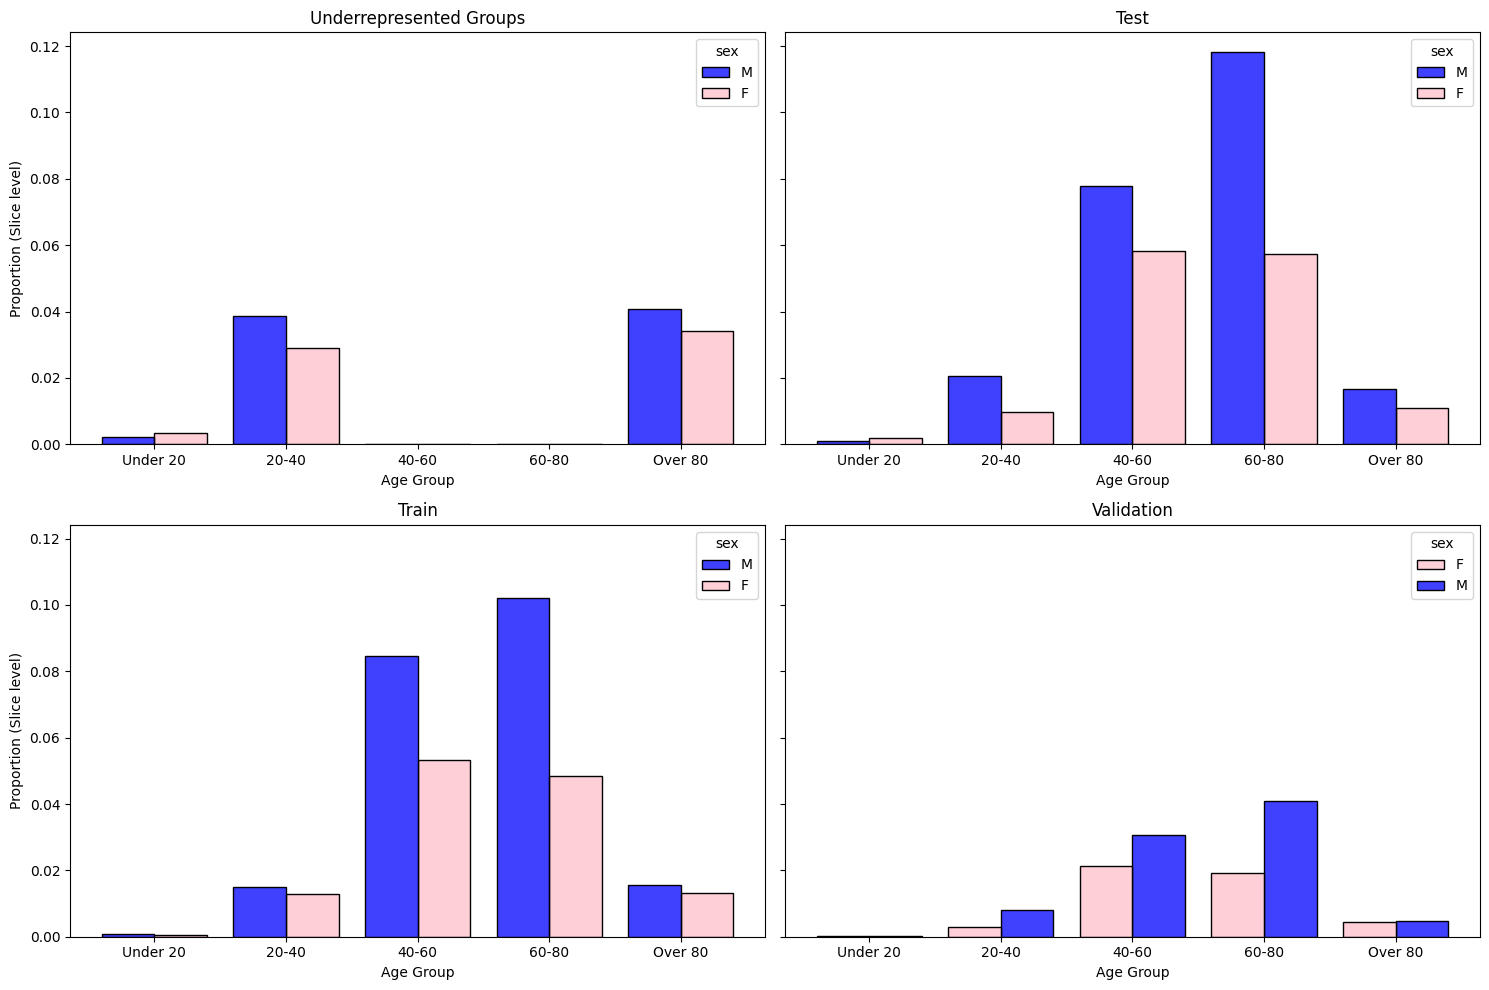

In [22]:
# Create 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=True)
# Flatten axes array for easy indexing
axes = axes.flatten()

# Define splits and titles
splits = ['ground_truth','test', 'train', 'val']
titles = ['Underrepresented Groups', 'Test', 'Train', 'Validation']

# Plot histograms
for i, split in enumerate(splits):
    ax = axes[i]
    sns.histplot(data=df[df['split'] == split], x='age_group', hue='sex',
             multiple='dodge', shrink=0.8,
             weights='weight',  # normalize by total
             palette=custom_palette, ax=ax)
    ax.set_title(titles[i])
    ax.set_xlabel('Age Group')
    ax.set_ylabel('Proportion (Slice level)')
    ax.tick_params(axis='x', rotation=0)

plt.tight_layout()

In [ ]:
# 80 - 20 (or play around with the sizes)
# do it for all the 10 subgroups !!!!
# create the 5 variations of the synthetic set of the version of the GT i end up getting

In [5]:
df[(df["split"]=='test')&(df["age_group"]=='Over 80')][["sex", "label"]].value_counts(normalize=True)

sex  label
M    1        0.603352
F    1        0.396648
Name: proportion, dtype: float64

In [7]:
df[(df["age_group"]=='Over 80')][["split", "sex", "label"]].value_counts(normalize=True)

split         sex  label
ground_truth  M    1        0.289937
              F    1        0.243951
test          M    1        0.118576
train         M    1        0.110173
              F    1        0.088045
test          F    1        0.077953
val           M    1        0.033149
              F    1        0.032220
train         F    0        0.005996
Name: proportion, dtype: float64

In [8]:
df[(df["age_group"]=='Over 80')][["split", "sex", "label"]].value_counts(normalize=False)

split         sex  label
ground_truth  M    1        6866
              F    1        5777
test          M    1        2808
train         M    1        2609
              F    1        2085
test          F    1        1846
val           M    1         785
              F    1         763
train         F    0         142
Name: count, dtype: int64

# redistribution

In [3]:
df_new = df[df['split'].isin(["test", "ground_truth"])]
df_new

,fname,image_path,patient_id,series_num,age,age_group,sex,finding,label,use,split
0,NCP_1002_2561_0020.png,/home/vito/fortunom/projects/AI4Health/data/fo...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test
1,NCP_1002_2561_0021.png,/home/vito/fortunom/projects/AI4Health/data/fo...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test
2,NCP_1002_2561_0022.png,/home/vito/fortunom/projects/AI4Health/data/fo...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test
3,NCP_1002_2561_0023.png,/home/vito/fortunom/projects/AI4Health/data/fo...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test
4,NCP_1002_2561_0024.png,/home/vito/fortunom/projects/AI4Health/data/fo...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test
...,...,...,...,...,...,...,...,...,...,...,...
168518,COVIDCTMD-normal075-IM0155.png,/home/vito/fortunom/projects/AI4Health/data/fo...,COVIDCTMD-normal075,NaN,56.0,40-60,M,Normal,0,True,test
168519,COVIDCTMD-normal075-IM0156.png,/home/vito/fortunom/projects/AI4Health/data/fo...,COVIDCTMD-normal075,NaN,56.0,40-60,M,Normal,0,True,test
168520,COVIDCTMD-normal075-IM0157.png,/home/vito/fortunom/projects/AI4Health/data/fo...,COVIDCTMD-normal075,NaN,56.0,40-60,M,Normal,0,True,test
168521,COVIDCTMD-normal075-IM0158.png,/home/vito/fortunom/projects/AI4Health/data/fo...,COVIDCTMD-normal075,NaN,56.0,40-60,M,Normal,0,True,test


In [4]:
print(df_new["patient_id"].nunique())
print(df["patient_id"].nunique())

933
1718


In [5]:
df_new[["sex", "age_group", "label"]].value_counts()

sex  age_group  label
M    60-80      1        19478
     40-60      1        11251
     Over 80    1         9674
F    60-80      1         9470
     40-60      1         8321
     Over 80    1         7623
M    20-40      1         5422
                0         4549
F    20-40      0         3266
                1         3263
M    40-60      0         1881
F    40-60      0         1519
M    60-80      0          467
F    Under 20   1          457
                0          441
M    Under 20   1          437
F    60-80      0          179
M    Under 20   0          100
Name: count, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

df_patient = df_new.groupby("patient_id").agg({"sex":"first", "age_group":"first", "label":"first"}).reset_index()
gt_patients, test_patients= train_test_split(df_patient,
        train_size=0.90,
        test_size=0.10,
        stratify=df_patient[["sex", "age_group", "label"]],
        random_state=42
    )

def assign_split(df, split_name):
    df = df[['patient_id']].copy()
    df['2_new_split'] = split_name
    return df

split_assignments = pd.concat([
    assign_split(gt_patients, 'ground_truth'),
    assign_split(test_patients, 'test'),
])

df_new = df_new.merge(split_assignments, on='patient_id', how='left')

In [7]:
df_new["2_new_split"].value_counts()

2_new_split
ground_truth    79474
test             8324
Name: count, dtype: int64

In [9]:
df_new[df_new["2_new_split"]=="ground_truth"][["sex", "age_group", "label"]].value_counts()

sex  age_group  label
M    60-80      1        17243
     40-60      1        10463
     Over 80    1         9061
F    60-80      1         8668
     40-60      1         7534
     Over 80    1         6817
M    20-40      1         5007
                0         3910
F    20-40      1         2993
                0         2761
M    40-60      0         1659
F    40-60      0         1433
M    60-80      0          436
F    Under 20   0          428
M    Under 20   1          396
F    Under 20   1          386
     60-80      0          179
M    Under 20   0          100
Name: count, dtype: int64

In [10]:
df_new[df_new["2_new_split"]=="test"][["sex", "age_group", "label"]].value_counts()

sex  age_group  label
M    60-80      1        2235
F    Over 80    1         806
     60-80      1         802
M    40-60      1         788
F    40-60      1         787
M    20-40      0         639
     Over 80    1         613
F    20-40      0         505
M    20-40      1         415
F    20-40      1         270
M    40-60      0         222
F    40-60      0          86
     Under 20   1          71
M    Under 20   1          41
     60-80      0          31
F    Under 20   0          13
Name: count, dtype: int64

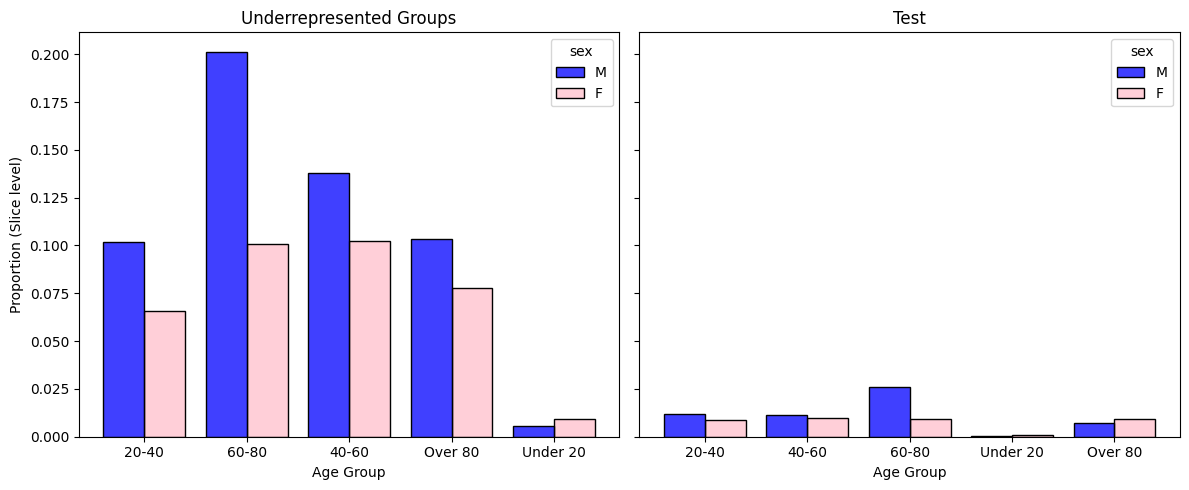

In [11]:
df_new['2_new_weight'] = 1 / len(df_new)

# Create 2x2 grid
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
# Flatten axes array for easy indexing
axes = axes.flatten()
custom_palette = {
    'M': 'blue',
    'F': 'pink'
}

# Define splits and titles
splits = ['ground_truth', 'test',]
titles = ['Underrepresented Groups', 'Test',]

# Plot histograms
for i, split in enumerate(splits):
    ax = axes[i]
    sns.histplot(data=df_new[df_new['2_new_split'] == split], x='age_group', hue='sex',
             multiple='dodge', shrink=0.8,
             weights='2_new_weight',  # normalize by total
             palette=custom_palette, ax=ax)
    ax.set_title(titles[i])
    ax.set_xlabel('Age Group')
    ax.set_ylabel('Proportion (Slice level)')
    ax.tick_params(axis='x', rotation=0)

plt.tight_layout()

In [10]:
df_new[df_new['new_split']=='ground_truth'][["sex", "age_group", "label"]].value_counts(normalize=False)

sex  age_group  label
M    60-80      1        15631
     40-60      1         9023
     Over 80    1         7820
F    60-80      1         7749
     40-60      1         6907
     Over 80    1         6109
M    20-40      1         4364
                0         3620
F    20-40      1         2680
                0         2588
M    40-60      0         1390
F    40-60      0         1292
M    60-80      0          436
F    Under 20   0          428
M    Under 20   1          396
F    Under 20   1          358
     60-80      0          179
M    Under 20   0           67
Name: count, dtype: int64

In [11]:
df_new[df_new['new_split']=='test'][["sex", "age_group", "label"]].value_counts(normalize=False)

sex  age_group  label
M    60-80      1        3847
     40-60      1        2228
     Over 80    1        1854
F    60-80      1        1721
     Over 80    1        1514
     40-60      1        1414
M    20-40      1        1058
                0         929
F    20-40      0         678
                1         583
M    40-60      0         491
F    40-60      0         227
     Under 20   1          99
M    Under 20   1          41
                0          33
     60-80      0          31
F    Under 20   0          13
Name: count, dtype: int64

In [12]:
df_new[["fname", "2_new_split"]].head()

,fname,2_new_split
0,NCP_1002_2561_0020.png,ground_truth
1,NCP_1002_2561_0021.png,ground_truth
2,NCP_1002_2561_0022.png,ground_truth
3,NCP_1002_2561_0023.png,ground_truth
4,NCP_1002_2561_0024.png,ground_truth


In [13]:
df_new["2_new_split"].value_counts(normalize=True)

2_new_split
ground_truth    0.905191
test            0.094809
Name: proportion, dtype: float64

In [15]:
df_2 = pd.read_csv("/home/vito/fortunom/projects/AI4Health/data/fortunom/covidxct/NEW_proc_slices_metadata.csv")
df_2.head()

,fname,image_path,patient_id,series_num,age,age_group,sex,finding,label,use,split,new_split
0,NCP_1002_2561_0020.png,/home/vito/fortunom/projects/AI4Health/data/fo...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test,test
1,NCP_1002_2561_0021.png,/home/vito/fortunom/projects/AI4Health/data/fo...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test,test
2,NCP_1002_2561_0022.png,/home/vito/fortunom/projects/AI4Health/data/fo...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test,test
3,NCP_1002_2561_0023.png,/home/vito/fortunom/projects/AI4Health/data/fo...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test,test
4,NCP_1002_2561_0024.png,/home/vito/fortunom/projects/AI4Health/data/fo...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test,test


In [16]:
df_final = df_2.merge(df_new[["fname", "2_new_split"]], on='fname', how='left')
df_final.head()

,fname,image_path,patient_id,series_num,age,age_group,sex,finding,label,use,split,new_split,2_new_split
0,NCP_1002_2561_0020.png,/home/vito/fortunom/projects/AI4Health/data/fo...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test,test,ground_truth
1,NCP_1002_2561_0021.png,/home/vito/fortunom/projects/AI4Health/data/fo...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test,test,ground_truth
2,NCP_1002_2561_0022.png,/home/vito/fortunom/projects/AI4Health/data/fo...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test,test,ground_truth
3,NCP_1002_2561_0023.png,/home/vito/fortunom/projects/AI4Health/data/fo...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test,test,ground_truth
4,NCP_1002_2561_0024.png,/home/vito/fortunom/projects/AI4Health/data/fo...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test,test,ground_truth


In [17]:
len(df_final[df_final["2_new_split"]=="ground_truth"])

79474

In [18]:
len(df_final[df_final["split"]=="ground_truth"])

24969

In [19]:
len(df_final[df_final["split"]=="test"])

62829

In [20]:
df_final.to_csv('/home/vito/fortunom/projects/AI4Health/data/fortunom/covidxct/NEW_proc_slices_metadata.csv', index=False)

In [21]:
df = pd.read_csv('/home/vito/fortunom/projects/AI4Health/data/fortunom/covidxct/NEW_proc_slices_metadata.csv')
df

,fname,image_path,patient_id,series_num,age,age_group,sex,finding,label,use,split,new_split,2_new_split
0,NCP_1002_2561_0020.png,/home/vito/fortunom/projects/AI4Health/data/fo...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test,test,ground_truth
1,NCP_1002_2561_0021.png,/home/vito/fortunom/projects/AI4Health/data/fo...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test,test,ground_truth
2,NCP_1002_2561_0022.png,/home/vito/fortunom/projects/AI4Health/data/fo...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test,test,ground_truth
3,NCP_1002_2561_0023.png,/home/vito/fortunom/projects/AI4Health/data/fo...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test,test,ground_truth
4,NCP_1002_2561_0024.png,/home/vito/fortunom/projects/AI4Health/data/fo...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test,test,ground_truth
...,...,...,...,...,...,...,...,...,...,...,...,...,...
168689,COVIDCTMD-normal076-IM0167.png,/home/vito/fortunom/projects/AI4Health/data/fo...,COVIDCTMD-normal076,NaN,30.0,20-40,M,Normal,0,True,val,NaN,NaN
168690,COVIDCTMD-normal076-IM0168.png,/home/vito/fortunom/projects/AI4Health/data/fo...,COVIDCTMD-normal076,NaN,30.0,20-40,M,Normal,0,True,val,NaN,NaN
168691,COVIDCTMD-normal076-IM0169.png,/home/vito/fortunom/projects/AI4Health/data/fo...,COVIDCTMD-normal076,NaN,30.0,20-40,M,Normal,0,True,val,NaN,NaN
168692,COVIDCTMD-normal076-IM0170.png,/home/vito/fortunom/projects/AI4Health/data/fo...,COVIDCTMD-normal076,NaN,30.0,20-40,M,Normal,0,True,val,NaN,NaN


# Results graphs

In [3]:
df_new_split = pd.read_excel("/home/vito/fortunom/projects/AI4Health/notebooks/fortunom/master-thesis/data/subpop_eval.xlsx", sheet_name="new_split")
df_new_split["subpop"] = df_new_split["subpop"].str.replace(" \\n ", "\n")

df_new_split

,subpop,metric,set,metric_mean,metric_ci
0,Under 20\nF,F1,GT,0.97,0.01
1,Under 20\nF,F1,Test,0.86,0.16
2,Under 20\nF,F1,SYN,0.97,0.06
3,Under 20\nF,AUC_PR,GT,1.00,0.00
4,Under 20\nF,AUC_PR,Test,1.00,0.00
...,...,...,...,...,...
85,Over 80\nM,AUC_PR,Test,NaN,NaN
86,Over 80\nM,AUC_PR,SYN,NaN,NaN
87,Over 80\nM,MCC,GT,NaN,NaN
88,Over 80\nM,MCC,Test,NaN,NaN


In [4]:
df_sizes = pd.read_excel("/home/vito/fortunom/projects/AI4Health/notebooks/fortunom/master-thesis/data/subpop_eval.xlsx", sheet_name="sample_sizes")
df_sizes

,origin,subgroup,split,size
0,original,Under 20 \n F,GT,577
1,original,Under 20 \n F,Test,321
2,new,Under 20 \n F,GT,786
3,new,Under 20 \n F,Test,112
4,original,Under 20 \n M,GT,369
5,original,Under 20 \n M,Test,168
6,new,Under 20 \n M,GT,463
7,new,Under 20 \n M,Test,74
8,original,20-40 \n F,GT,4869
9,original,20-40 \n F,Test,1660


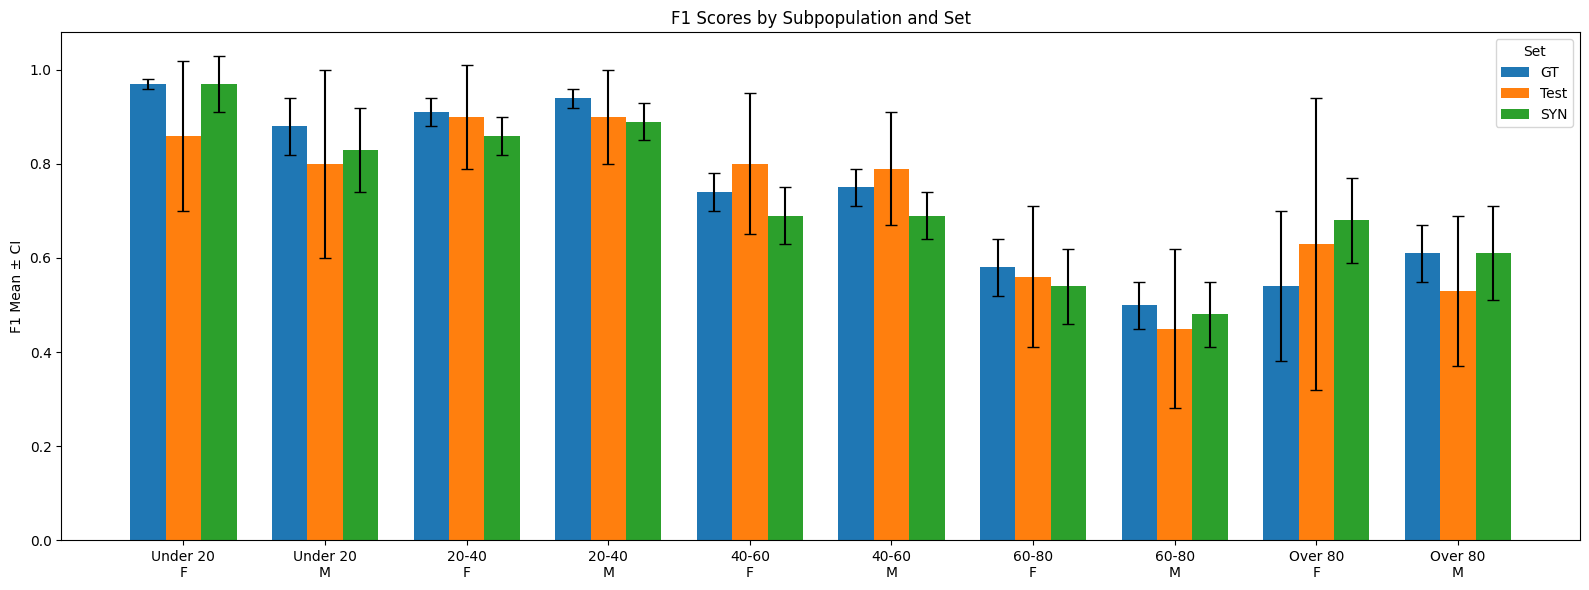

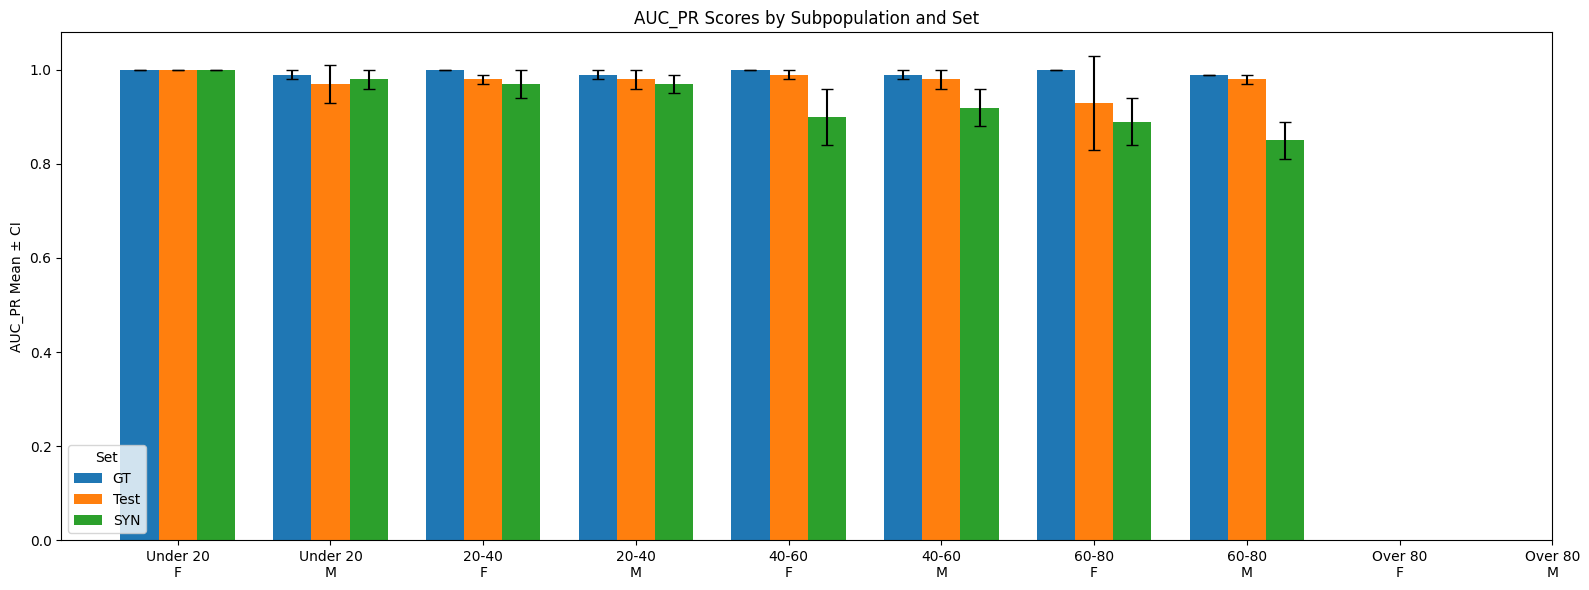

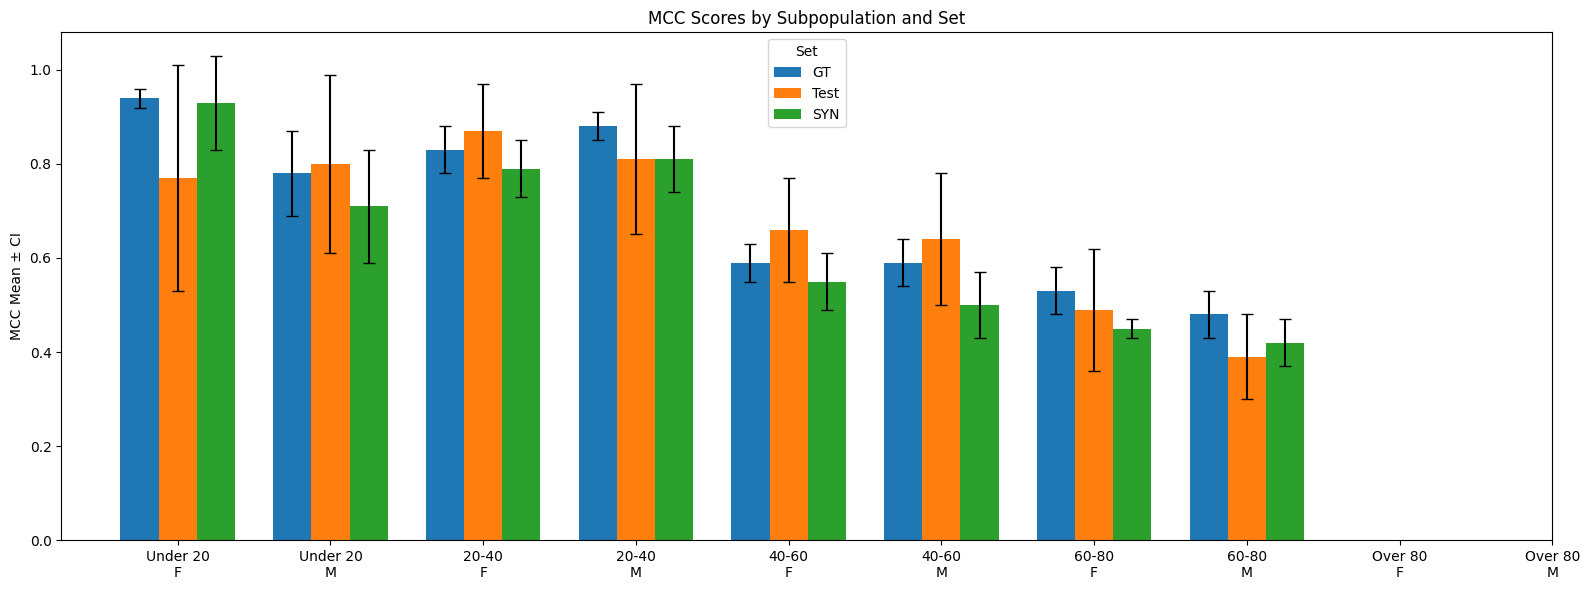

In [5]:
for metric in df_new_split["metric"].unique():
    df_metric = df_new_split[df_new_split["metric"] == metric]

    subpops = df_metric["subpop"].unique()
    sets = df_metric["set"].unique()
    bar_width = 0.25
    x = np.arange(len(subpops))  # positions for subpop groups

    plt.figure(figsize=(16, 6))

    for i, s in enumerate(sets):
        df_s = df_metric[df_metric["set"] == s].set_index("subpop").reindex(subpops)
        means = df_s["metric_mean"].values
        cis = df_s["metric_ci"].values
        plt.bar(
            x + i * bar_width,
            means,
            width=bar_width,
            label=s,
            yerr=cis,
            capsize=4,
            color=plt.get_cmap("tab10")(i)
        )

    plt.xticks(x + bar_width, subpops, rotation=0, ha='center')
    plt.ylim(0, max(df_metric["metric_mean"] + df_metric["metric_ci"]) + 0.05)
    plt.ylabel(f"{metric} Mean ± CI")
    plt.title(f"{metric} Scores by Subpopulation and Set")
    plt.legend(title="Set")
    plt.tight_layout()
    plt.show()
